In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy.special import expit
import matplotlib.pyplot as plt

wine_data = scipy.io.loadmat('data.mat')
training_data, training_labels = wine_data['X'], wine_data['y']
test_data = wine_data['X_test']

In [2]:
# Data processing
np.random.seed(189)

# Normalize data
means, std = np.mean(training_data, axis=0), np.std(training_data, axis=0)
normalized_traininig_data, normalized_test_data = (training_data - means) / std, (test_data - means) / std

# Adding fictious feature
add_training_data = np.append(normalized_traininig_data, np.ones((len(normalized_traininig_data), 1)), axis=1)
add_test_data = np.append(normalized_test_data, np.ones((len(normalized_test_data), 1)), axis=1)

# Shuffle
idx = np.random.permutation(len(add_training_data))
shuffled_training_data, shuffled_training_labels = add_training_data[idx], training_labels[idx]
# Split
split_training_data, split_training_labels = shuffled_training_data[1000:], shuffled_training_labels[1000:]
valid_training_data, valid_training_labels = shuffled_training_data[:1000], shuffled_training_labels[:1000]

In [3]:
# Helper func
def cost_fn(z, y, lamda, w):
    return np.sum(-y*np.log(z)-(1-y)*np.log(1-z)) + lamda * np.sum(w**2)

def eval(pred, y):
    return np.mean(y == pred)

def predict(X, w):
    probabilities = expit(np.dot(X, w))
    predictions = (probabilities >= 0.5).astype(int)
    return predictions

def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv('submission.csv', index_label='Id')

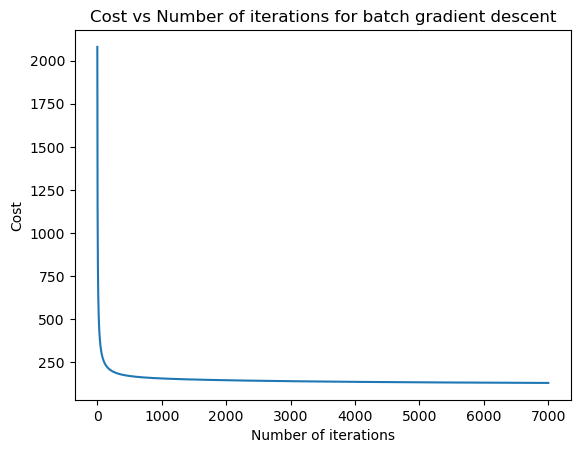

In [4]:
# Batch Gradient Descent
def batch_gradient(w, X, y, lamda, e):
    return w - e * (X.T @ (expit(X @ w) - y) + lamda * w)

w = np.zeros((len(split_training_data[0]), 1))  # Initialized with zeros
lamda = 0.1
e = 0.0001
cost = []

for i in range(7000):
    w = batch_gradient(w, split_training_data, split_training_labels, lamda, e)
    s = expit(split_training_data @ w)
    val = cost_fn(s, split_training_labels, lamda, w)
    cost.append(val)

plt.plot(range(len(cost)), cost)
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.title('Cost vs Number of iterations for batch gradient descent')
plt.show()

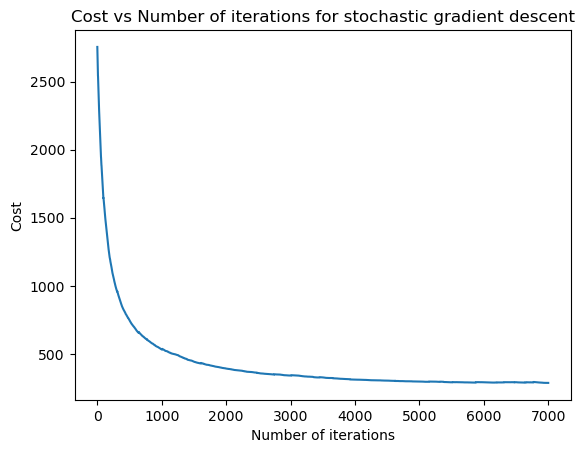

In [5]:
# Stochastic Gradient Descent
np.random.seed(189)
def stochasitc_gradient(w, X, y, lamda, e):
    n = len(X)
    i = np.random.randint(0, n)
    x_i, y_i = X[i].reshape(-1, 1), y[i]
    s = expit(x_i.T @ w)
    gradient = np.multiply(x_i, (s-y_i)) + lamda * w
    return w - e * gradient

w = np.zeros((len(split_training_data[0]), 1))
lamda = 0.01
e = 0.01
sto_cost = []

for i in range(7000):
    w = stochasitc_gradient(w, split_training_data, split_training_labels, lamda, e)
    s = expit(split_training_data @ w)
    val = cost_fn(s, split_training_labels, lamda, w)
    sto_cost.append(val)

plt.plot(range(len(sto_cost)), sto_cost)
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.title('Cost vs Number of iterations for stochastic gradient descent')
plt.show()

In [6]:
# BGD Prediction
w = np.zeros((len(split_training_data[0]), 1))  # Initialized with zeros
for i in range(7000):
    w = batch_gradient(w, split_training_data, split_training_labels, 0.1, 0.0001)

pred = predict(valid_training_data, w)
print(f"BGD Accuracy: {eval(pred, valid_training_labels)}")

pred_test = predict(add_test_data, w)
# results_to_csv(pred_test.flatten())

BGD Accuracy: 0.998


In [7]:
# SGD prediction
w = np.zeros((len(split_training_data[0]), 1))  # Initialized with zeros
for i in range(7000):
    w = stochasitc_gradient(w, split_training_data, split_training_labels, 0.01, 0.01)

pred = predict(valid_training_data, w)
print(f"SGD Accuracy: {eval(pred, valid_training_labels)}")

pred_test = predict(add_test_data, w)
# results_to_csv(pred_test.flatten())

SGD Accuracy: 0.994


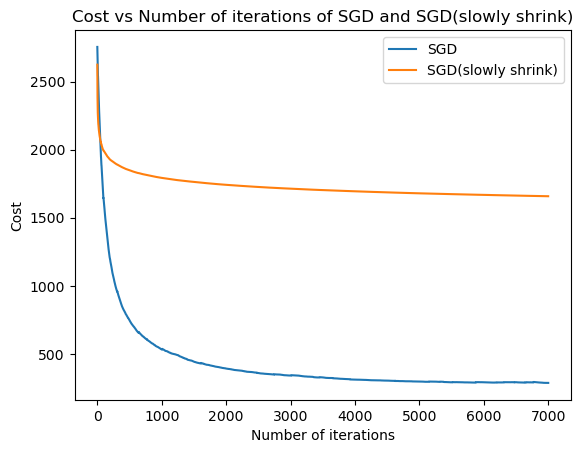

In [8]:
# Plot to compare SGD and slowly shrinks SGD
np.random.seed(189)
w = np.zeros((len(split_training_data[0]), 1))
lamda = 0.01
e = 0.1
sto_cost2 = []

for i in range(1, 7000):
    w = stochasitc_gradient(w, split_training_data, split_training_labels, lamda, e / i)
    s = expit(split_training_data @ w)
    val = cost_fn(s, split_training_labels, lamda, w)
    sto_cost2.append(val)

plt.plot(range(len(sto_cost)), sto_cost, label='SGD')
plt.plot(range(len(sto_cost2)), sto_cost2, label='SGD(slowly shrink)')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.title('Cost vs Number of iterations of SGD and SGD(slowly shrink)')
plt.show()